# Total number of unique cyclones in this data set is 1,973.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '../data/hurdat2_1851_2023.txt'

column_names = ['Date', 'Time', 'Record ID', 'Status', 
                'Latitude', 'Longitude', 'WindSpeed', 
                'Pressure', 'Rad_34_NE', 'Rad_34_SE', 
                'Rad_34_SW', 'Rad_34_NW', 'Rad_50_NE', 'Rad_50_SE',
                'Rad_50_SW', 'Rad_50_NW', 'Rad_64_NE', 'Rad_64_SE', 
                'Rad_64_SW', 'Rad_64_NW', 'Rad_maxwnd']

In [2]:
# Initialize variables
cyclone_data = []
current_cyclone = None

# Function to convert latitude and longitude to float
def convert_lat_lon(value):
    if 'N' in value or 'E' in value:
        return float(value[:-1])
    elif 'S' in value or 'W' in value:
        return -float(value[:-1])

# Read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        # Check if the line starts with 'AL' indicating a new cyclone
        if line.startswith('AL'):
            if current_cyclone is not None:
                cyclone_data.append(current_cyclone)
            current_cyclone = {'header': line.strip(), 'data': []}
        else:
            if current_cyclone is not None:
                current_cyclone['data'].append(line.strip().split(','))

# Append the last cyclone
if current_cyclone is not None:
    cyclone_data.append(current_cyclone)

# Process each cyclone's data
all_cyclone_dfs = []
for cyclone in cyclone_data:
    df = pd.DataFrame(cyclone['data'], columns=['Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude', 'WindSpeed', 'Pressure',
                                                'Rad_34_NE', 'Rad_34_SE', 'Rad_34_SW', 'Rad_34_NW', 'Rad_50_NE', 'Rad_50_SE',
                                                'Rad_50_SW', 'Rad_50_NW', 'Rad_64_NE', 'Rad_64_SE', 'Rad_64_SW', 'Rad_64_NW', 'maxwnd'])
    # Convert data types where necessary
    df['Date'] = df['Date'].astype(str)
    df['Time'] = df['Time'].astype(str)
    df['Latitude'] = df['Latitude'].apply(convert_lat_lon)
    df['Longitude'] = df['Longitude'].apply(convert_lat_lon)
    df['WindSpeed'] = df['WindSpeed'].astype(int)
    df['Pressure'] = df['Pressure'].astype(int)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y%m%d %H%M')
    df.set_index('Datetime', inplace=True)
    df['Cyclone'] = cyclone['header']  # Add a column for the cyclone identifier
    all_cyclone_dfs.append(df)

# Concatenate all cyclone dataframes into a single dataframe
all_data = pd.concat(all_cyclone_dfs)

# Move the Cyclone column to the first position
columns = ['Cyclone'] + [col for col in all_data.columns if col != 'Cyclone']
all_data = all_data[columns]

# Define the priority order for statuses
priority_order = {'HU': 1, 'TS': 2, 'TD': 3}
all_data['StatusPriority'] = all_data['Status'].map(priority_order).fillna(4)

# Sort by Cyclone and StatusPriority
all_data.sort_values(by=['Cyclone', 'StatusPriority'], inplace=True)

# Extract the first entry for each cyclone based on priority
greatest_status_per_cyclone = all_data.groupby('Cyclone').first().reset_index()

# Drop the StatusPriority column as it is no longer needed
greatest_status_per_cyclone.drop(columns=['StatusPriority'], inplace=True)

# Display the first few rows of the greatest status per cyclone
print(greatest_status_per_cyclone.head())

# Perform value counts on the 'Status' column within the filtered data
status_counts = greatest_status_per_cyclone['Status'].value_counts()
print(status_counts)

# Plot the value counts


# Optionally, if you want to count the number of unique cyclones
unique_cyclones = greatest_status_per_cyclone['Cyclone'].nunique()
print(f"Number of unique cyclones: {unique_cyclones}")


                                 Cyclone      Date   Time Record Status  \
0  AL011851,            UNNAMED,     14,  18510625   0000            HU   
1  AL011852,            UNNAMED,     45,  18520819   0000            TS   
2  AL011853,            UNNAMED,      1,  18530805   1200            TS   
3  AL011854,            UNNAMED,     11,  18540625   0000            TS   
4  AL011855,            UNNAMED,      1,  18550806   1200            HU   

   Latitude  Longitude  WindSpeed  Pressure Rad_34_NE  ... Rad_34_NW  \
0      28.0      -94.8         80      -999      -999  ...      -999   
1      20.5      -67.1         60      -999      -999  ...      -999   
2      32.5      -69.0         50      -999      -999  ...      -999   
3      26.0      -92.5         60      -999      -999  ...      -999   
4      22.2      -98.0         90      -999      -999  ...      -999   

  Rad_50_NE Rad_50_SE Rad_50_SW Rad_50_NW Rad_64_NE Rad_64_SE Rad_64_SW  \
0      -999      -999      -999      -999

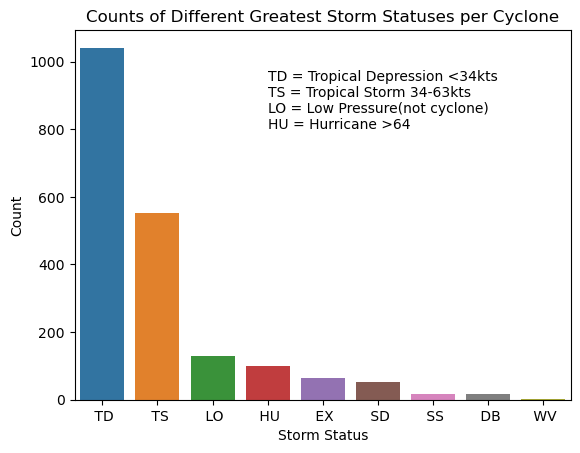

In [33]:
fig, ax = plt.subplots()
sns.barplot(x=status_counts.index, y=status_counts)
plt.title('Counts of Different Greatest Storm Statuses per Cyclone')
plt.xlabel('Storm Status')
plt.ylabel('Count')
plt.text(3, 800, 'TD = Tropical Depression <34kts\nTS = Tropical Storm 34-63kts\nLO = Low Pressure(not cyclone)\nHU = Hurricane >64')
plt.show()

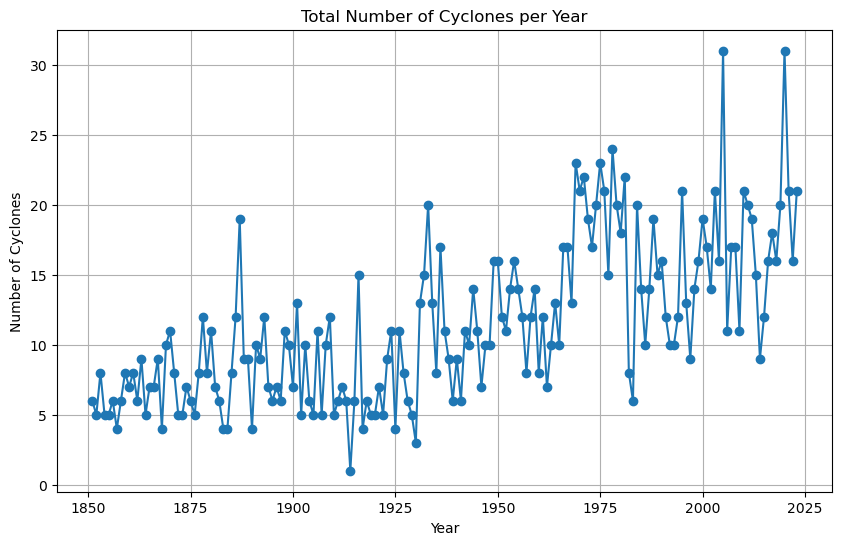

In [11]:
# Extract the year from the Datetime column
all_data['Year'] = all_data.index.year

# Group by year and count unique cyclones
cyclones_per_year = all_data.groupby('Year')['Cyclone'].nunique()

# Plot the total number of cyclones per year
plt.figure(figsize=(10, 6))
cyclones_per_year.plot(kind='line', marker='o')
plt.title('Total Number of Cyclones per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cyclones')
plt.grid(True)
plt.show()

In [58]:
scatter_cyclones_per_year = all_data.groupby('Year')['Cyclone'].nunique()
scatter_cyclones_per_year

Year
1851     6
1852     5
1853     8
1854     5
1855     5
        ..
2019    20
2020    31
2021    21
2022    16
2023    21
Name: Cyclone, Length: 173, dtype: int64

In [69]:
z = np.polyfit(scatter_cyclones_per_year.index, scatter_cyclones_per_year, 2)
p = np.poly1d(z)

Text(0, 0.5, 'Number of Cyclones')

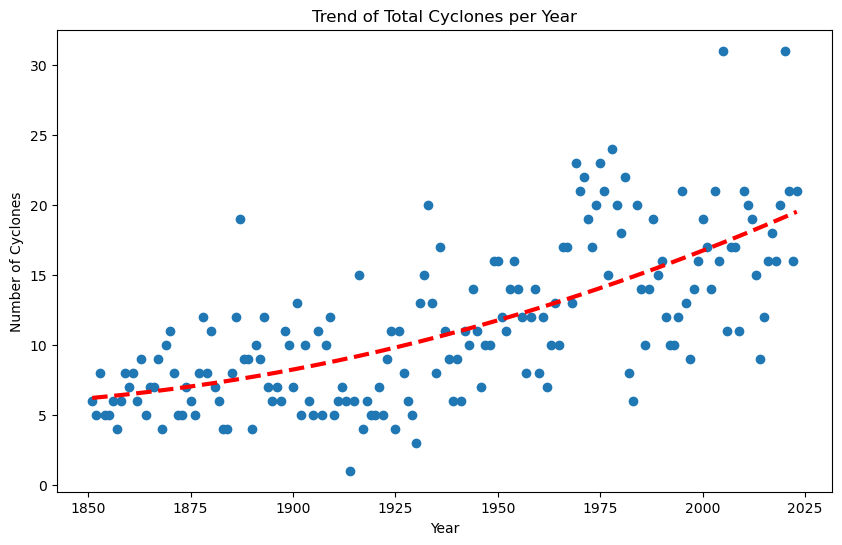

In [133]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x=scatter_cyclones_per_year.index, y=scatter_cyclones_per_year)
ax.plot(scatter_cyclones_per_year.index, p(scatter_cyclones_per_year.index), color="r", linewidth=3, linestyle="--")
ax.set_title('Trend of Total Cyclones per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Cyclones')

In [156]:
rolmean = pd.Series(scatter_cyclones_per_year).rolling(window=5).mean()
rolmean

Year
1851     NaN
1852     NaN
1853     NaN
1854     NaN
1855     5.8
        ... 
2019    16.4
2020    20.2
2021    21.2
2022    20.8
2023    21.8
Name: Cyclone, Length: 173, dtype: float64

In [157]:
rolstd = pd.Series(scatter_cyclones_per_year).rolling(window=5).std()
rolstd

Year
1851         NaN
1852         NaN
1853         NaN
1854         NaN
1855    1.303840
          ...   
2019    2.966479
2020    6.260990
2021    5.805170
2022    6.140033
2023    5.540758
Name: Cyclone, Length: 173, dtype: float64

In [160]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [164]:
new_test = pd.Series(scatter_cyclones_per_year)
new_test

Year
1851     6
1852     5
1853     8
1854     5
1855     5
        ..
2019    20
2020    31
2021    21
2022    16
2023    21
Name: Cyclone, Length: 173, dtype: int64

In [161]:
def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

In [170]:
new_new = new_test.index
new_two = pd.Series(new_new)

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is nan
The Root Mean Squared Error of our forecasts with auto optimization is nan


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836

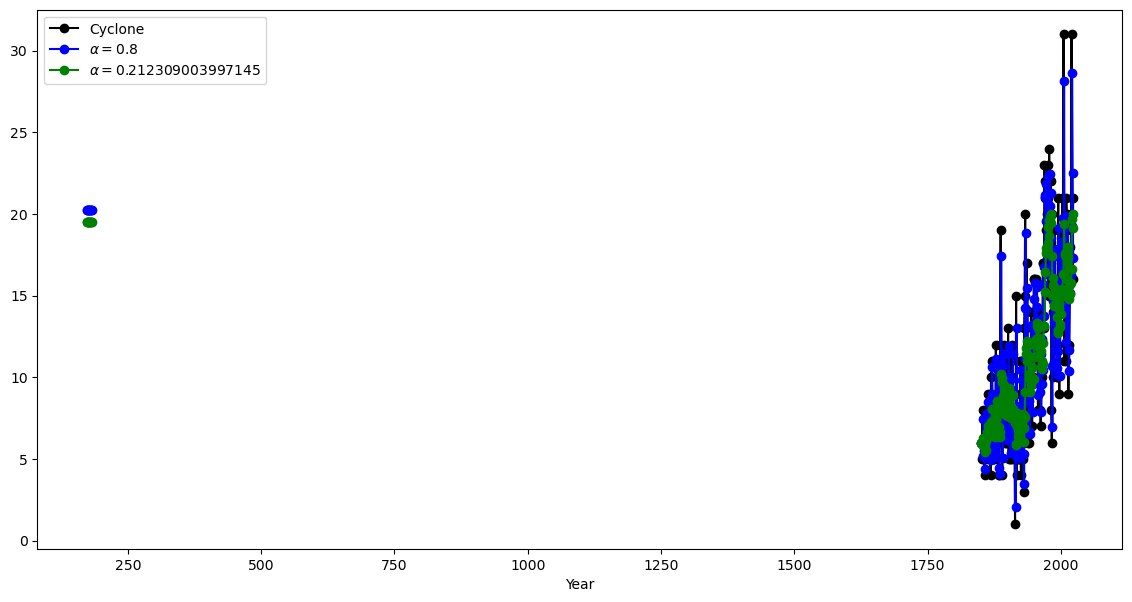

In [173]:
ses(new_test, new_test, new_two,0.8, 10)

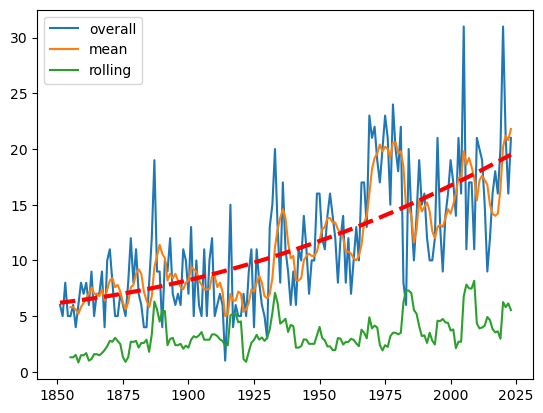

In [159]:
fig, ax = plt.subplots()
ax.plot(scatter_cyclones_per_year, label='overall')
ax.plot(rolmean, label='mean')
ax.plot(rolstd, label='rolling')
ax.plot(scatter_cyclones_per_year.index, p(scatter_cyclones_per_year.index), color="r", linewidth=3, linestyle="--")
ax.legend()

In [ ]:


fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x=scatter_cyclones_per_year.index, y=scatter_cyclones_per_year)
ax.plot(scatter_cyclones_per_year.index, p(scatter_cyclones_per_year.index), color="r", linewidth=3, linestyle="--")
scatter_cyclones_per_year.append(date_end)
plt.plot
ax.set_title('Trend of Total Cyclones per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Cyclones')

Text(0, 0.5, 'Number of Cyclones')

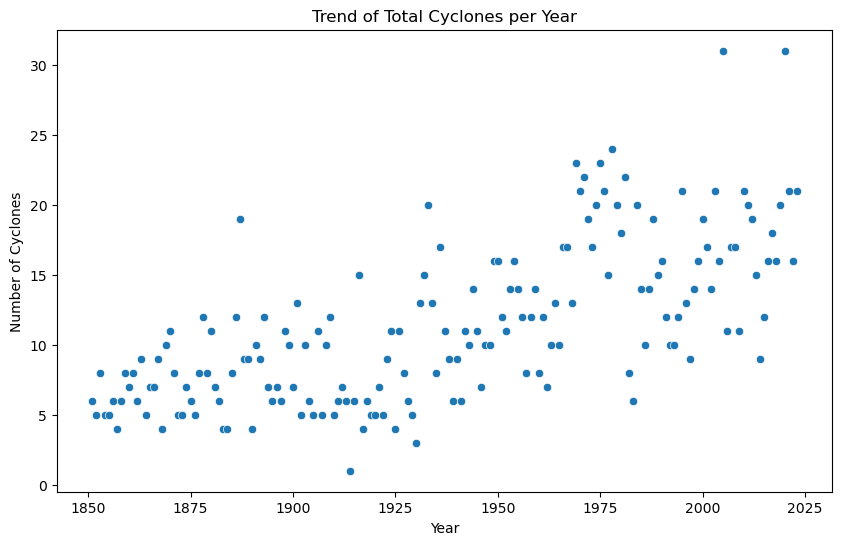

In [85]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=scatter_cyclones_per_year.index, y=scatter_cyclones_per_year)
ax.set_title('Trend of Total Cyclones per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Cyclones')

In [102]:
all_data.head(1)

,Cyclone,Date,Time,Record,Status,Latitude,Longitude,WindSpeed,Pressure,Rad_34_NE,...,Rad_50_SE,Rad_50_SW,Rad_50_NW,Rad_64_NE,Rad_64_SE,Rad_64_SW,Rad_64_NW,maxwnd,StatusPriority,Year
Datetime,,,,,,,,,,,,,,,,,,,,,
1851-06-25,"AL011851, UNNAMED, 14,",18510625,0000,,HU,28.0,-94.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,4.0,1851


In [100]:
test_test = all_data
test_test.head(1)

,Cyclone,Date,Time,Record,Status,Latitude,Longitude,WindSpeed,Pressure,Rad_34_NE,...,Rad_34_NW,Rad_50_NE,Rad_50_SE,Rad_50_SW,Rad_50_NW,Rad_64_NE,Rad_64_SE,Rad_64_SW,Rad_64_NW,maxwnd
0,"AL011851, UNNAMED, 14,",18510625,0000,,HU,28.0,-94.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [107]:
test_test = all_data.groupby('Year')['Cyclone'].nunique()
test_test
#['Year'] = test_test.index[1].year

Year
1851     6
1852     5
1853     8
1854     5
1855     5
        ..
2019    20
2020    31
2021    21
2022    16
2023    21
Name: Cyclone, Length: 173, dtype: int64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Number of Cyclones')

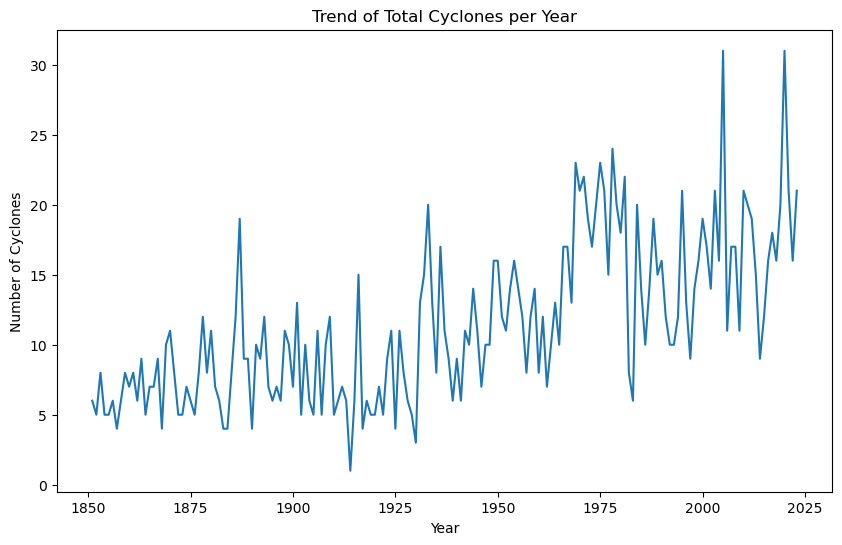

In [120]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=test_test, x='Year', y=test_test)
ax.set_title('Trend of Total Cyclones per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Cyclones')

In [26]:
# Plot the total number of cyclones per year
plt.figure(figsize=(10, 6))
plt.scatter(x=all_data['Year'], y=unique_cyclones['cyclone'].nunique())
plt.title('Total Number of Cyclones per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cyclones')
plt.grid(True)
plt.show()

TypeError: 'int' object is not subscriptable

<Figure size 1000x600 with 0 Axes>